# Übung 2: Predicting Conversion Rate

**Description**:    
Data about users for a website: 
* Whether they converted or not
* ISP country of origin
* Marketing channel taken to conversion
* Age
* Whether they are repeat users or not
* Number of pages visited during that session

**Goal**:   
Build a model which predicts conversion rate and, based on this model, give recommendations to the product and marketing teams to improve conversion rate  

## Import Libraries and Load Data

First, import all necessary libraries.

In [0]:
# Analysis imports
import numpy as np
import pandas as pd

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ML imports
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Miscellaneous imports
import warnings
warnings.filterwarnings('ignore')

Next, I'll load the data.

In [115]:
df = pd.read_csv("https://raw.githubusercontent.com/pwinslow/Conversion-Rate-Optimization/master/conversion_data.csv")
df.head()

country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0

## Data Cleansing and Basic Descriptive Analysis

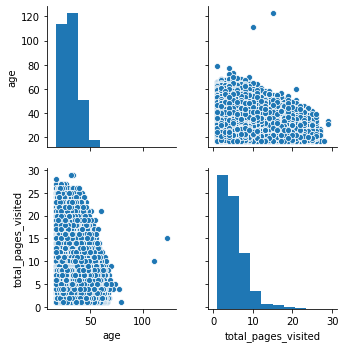

In [116]:
# Look for outliers or major skew
sns.pairplot(df[["age", "total_pages_visited"]])

Looks like a few outliers in age. No fancy stats method is needed here, just remove anything with an age > 80.

In [0]:
# Remove outliers
df = df[df.age < 80]

After cleaning and removing outliers, we can take a look at the overall descriptive statistics before moving on.

In [118]:
# List basic descriptive statistics for all numerical data
df.describe()

age       new_user  total_pages_visited      converted
count  316198.000000  316198.000000        316198.000000  316198.000000
mean       30.569311       0.685469             4.872918       0.032252
std         8.268958       0.464329             3.341053       0.176669
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max        79.000000       1.000000            29.000000       1.000000

I'll also visualize some aspects of the data.    

First, looking at the conversion rate per country we see that China sticks out quite a bit as these users tend to be very hard to convert. One possible reason is that marketing channels may be all english. If the company is interested in increasing Chinese conversion rates, perhaps they could look into translating some of the marketing channels to either Mandarin or Cantonese? Another feature to notice is that German users seem to be the easiest to convert. These points are particular poignant considering the comparison between populations (see 2nd plot below).

Text(0, 0.5, 'Conversion Rate')

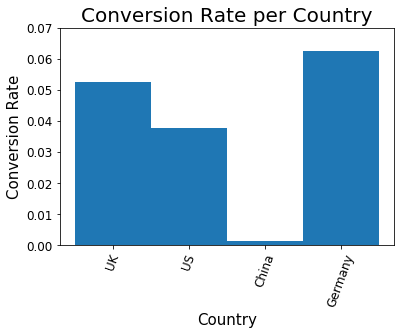

In [119]:
# Display conversion rates per country
country_conversion_rate = []
for country in df.country.unique():
    country_conversion_rate.append((country, 
                                    df[df.country == country].converted.sum() * 1.0 / 
                                    df[df.country == country].shape[0]))

labels, ys = zip(*country_conversion_rate)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels, fontsize=12, rotation=70)
plt.yticks([0, .01, .02, .03, .04, .05, .06, .07], fontsize=12)

plt.title("Conversion Rate per Country", fontsize=20)
plt.xlabel("Country", fontsize=15)
plt.ylabel("Conversion Rate", fontsize=15)

Text(0, 0.5, 'Population (millions)')

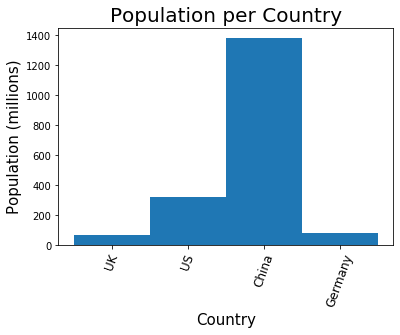

In [120]:
# Compare populations for each country
pops = [("UK",65111143 / 1000000.0), 
        ("US",324118787 / 1000000.0), 
        ("China",1382323332 / 1000000.0), 
        ("Germany",80682351 / 1000000.0)]

labels, ys = zip(*pops)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels, fontsize=12, rotation=70)
plt.title("Population per Country", fontsize=20)
plt.xlabel("Country", fontsize=15)
plt.ylabel("Population (millions)", fontsize=15)

Next, I plot the mean conversion rate per total pages visited. This presents a very clear pattern of "the more time spent on the site the more likely a user is to convert".

Text(0, 0.5, 'Mean conversion rate')

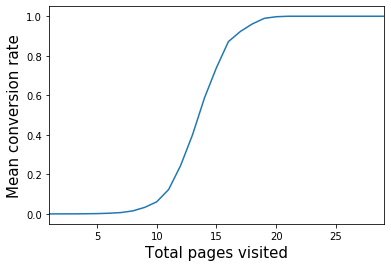

In [121]:
new_df = pd.DataFrame(columns=("total_pages_visited", "mean_conversion_rate"))
ser = df.groupby("total_pages_visited")["converted"].mean()
new_df.total_pages_visited = ser.index
new_df.mean_conversion_rate = ser.values

new_df.plot(x="total_pages_visited", y="mean_conversion_rate", kind="line", legend=None)
plt.xlabel("Total pages visited", fontsize=15)
plt.ylabel("Mean conversion rate", fontsize=15)

## Feature Engineering   

Here, I one-hot-encode the country and source categorial features and use standard normal scaling for the age and total_pages_visited features.

In [122]:
# Create dummy variables for country values
country_dummies = pd.get_dummies(df.country, prefix='country')
df = pd.concat([df, country_dummies], axis=1)

# Create dummy variables for source values
source_dummies = pd.get_dummies(df.source, prefix='source')
df = pd.concat([df, source_dummies], axis=1)

# Normally scale age and total_pages_visited features
feature_list = ["age", "total_pages_visited"]
feature_dict = {}
for feature in feature_list:
    feature_dict[feature + "_mean"] = df[feature].mean()
    feature_dict[feature + "_std"] = df[feature].std()
    df[feature] = (df[feature] - df[feature].mean()) * 1.0 / df[feature].std()

# Drop spurious columns
df.drop(["country", "source"], axis=1, inplace=True)

# Organize columns
df = df[["country_UK", 
            "country_US", 
            "country_Germany", 
            "country_China", 
            "source_Ads", 
            "source_Direct", 
            "source_Seo", 
            "age", 
            "new_user", 
            "total_pages_visited", 
            "converted"]]
df.head()

country_UK  country_US  ...  total_pages_visited  converted
0           1           0  ...            -1.159191          0
1           0           1  ...             0.038036          0
2           0           1  ...            -0.261270          0
3           0           0  ...             0.038036          0
4           0           1  ...             0.337343          0

[5 rows x 11 columns]

## Machine Learning   

Here, I split the data into 3 parts for training, hyperparameter tuning, and validation. I chose to use a random forest classification algorithm as it tends to require very little time to optimize, has lots of complexity to handle difficult datasets, and is also fairly robust against overfitting due to its nature of taking a majority vote of randomly generated weak learners. To account for the class imbalance in the data, I reweight the classes using the class_weight flag passed to the random forest classifier at initialization.

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
X = df[["country_UK", 
            "country_US", 
            "country_Germany", 
            "country_China", 
            "source_Ads", 
            "source_Direct", 
            "source_Seo", 
            "age", 
            "new_user", 
            "total_pages_visited"]]
Y = df["converted"]

# Split data
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.7, random_state=23)

# Initialize a random forest classifier
rf = RandomForestClassifier()

# Define a parameter grid to search over
param_dist = {"n_estimators": range(50, 250, 50),
              "max_depth": range(3, 7, 2), 
              'criterion': ['gini', 'entropy']}

# Setup 5-fold stratified cross validation
cross_validation = StratifiedKFold(n_splits=5)

# Randomly sample 10 hyperparameter configurations from the grid above and perform 5-fold cross validation for each
n_iter_search = 2
clf = RandomizedSearchCV(rf, 
                         param_distributions=param_dist, 
                         n_iter=n_iter_search, 
                         cv=cross_validation, 
                         n_jobs=10, 
                         verbose=10)
_ = clf.fit(X_dev, Y_dev)

rf_best = clf.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   36.0s remaining:  1.4min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:   41.1s remaining:   41.1s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:  1.5min remaining:   39.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.6min finished


Here, I validate the data by calculating the area under the curve in ROC space using only the validation dataset set aside earlier. Moreover, I also display a full classification report with precision, recall, and F-1 score.

Classification report for Random Forest
              precision    recall  f1-score   support

 unconverted       0.99      1.00      0.99     91702
   converted       0.88      0.63      0.74      3158

    accuracy                           0.98     94860
   macro avg       0.93      0.82      0.86     94860
weighted avg       0.98      0.98      0.98     94860

Area under ROC curve: 0.815


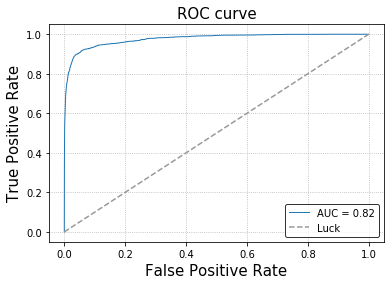

In [124]:
# Collect RF predictions
rf_Ypredicted = rf_best.predict(X_eval)
rf_roc_auc = roc_auc_score(Y_eval, rf_Ypredicted)

print("Classification report for Random Forest")
print(classification_report(Y_eval, 
                            rf_Ypredicted,
                            target_names=["unconverted", "converted"]))
print("Area under ROC curve: {:0.3f}".format(rf_roc_auc))


# Compute ROC curve and area under the curve for RF
rf_probs = rf_best.predict_proba(X_eval)[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(Y_eval, rf_probs)

plt.plot(rf_fpr, rf_tpr, lw=1, label='AUC = %0.2f'%(rf_roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve', fontsize=15)
plt.legend(loc="best", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

Let's now display the feature importances

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

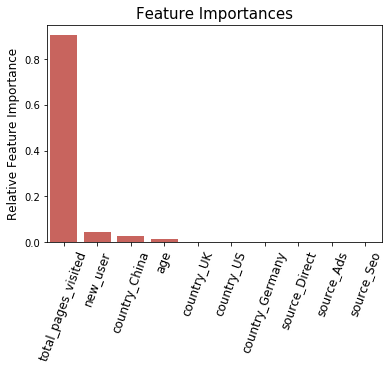

In [125]:
# For random forest, look at most important features
feat_labels = df.columns
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

sns.barplot(x=feat_labels[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=70)